<a href="https://colab.research.google.com/github/nachocarrera5/TA047R-1C2025-GRUPO04/blob/main/TA047R_TP1_GRUPO04_ENTREGA_EJ4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AGRUPAMIENTO (CLUSTERING)


GRUPO 04 - Integrantes:
*    Agustin Braida
*    Ignacio Carrera
*    Matias Etchegoyen
*    Agustin Trombetta
*    Tomas Ghiglione

## Exploración inicial

## Carga de datos

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import sklearn.preprocessing as skp

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.options.display.max_columns = None

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.neighbors import NearestNeighbors
from numpy.random import uniform, randint
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import zscore


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/Ciencia de datos/tp1/playlist_spotify.csv'
df = pd.read_csv(path)
df_base = df.copy(deep=True)
playlist_spotify = df.copy()

In [4]:
playlist_spotify.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.713,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143
1,0.192,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582
2,0.333,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199
3,0.601,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798
4,0.883,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288


In [5]:
spo = playlist_spotify.copy()

In [6]:
group1 = ['acousticness','danceability','energy','instrumentalness','liveness','speechiness','valence']
group2 = ['duration','key','loudness','mode','tempo','time_signature']

## Distribución de Variables

In [7]:
print(f"Dimensiones del dataset: {playlist_spotify.shape}")
print(playlist_spotify.info())

Dimensiones del dataset: (750, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      750 non-null    float64
 1   danceability      750 non-null    float64
 2   duration          750 non-null    int64  
 3   energy            750 non-null    float64
 4   instrumentalness  750 non-null    float64
 5   key               750 non-null    int64  
 6   liveness          750 non-null    float64
 7   loudness          750 non-null    float64
 8   mode              750 non-null    int64  
 9   speechiness       750 non-null    float64
 10  tempo             750 non-null    float64
 11  time_signature    750 non-null    int64  
 12  valence           750 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 76.3 KB
None


Todos los valores son numéricos

In [8]:
null_counts = playlist_spotify.isna().sum()
print(null_counts)

acousticness        0
danceability        0
duration            0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


Sin valores faltantes en el dataset

### Tendencia al Cluster

In [9]:
scaler = StandardScaler()

X_scaled_test = scaler.fit_transform(df)
X_scaled_df_test = pd.DataFrame(X_scaled_test, columns=df.columns)

In [10]:
def hopkins_st(X, sample_size=0.05, random_state=None):
    X = np.array(X)
    n = X.shape[0]
    d = X.shape[1]

    # Step 1: Generate uniform random sample
    X_uniform = uniform(np.min(X, axis=0), np.max(X, axis=0),
                       size=(int(sample_size * n), d))

    # Step 2: Randomly sample from original data
    np.random.seed(random_state)
    random_indices = randint(0, n, size=int(sample_size * n))
    X_sample = X[random_indices]

    # Step 3: Fit NearestNeighbors on original data
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)  # Only need 1 neighbor

    # Step 4: Distances for uniform sample (u_distances)
    u_distances, _ = nbrs.kneighbors(X_uniform, n_neighbors=1)
    u_sum = np.sum(u_distances)

    # Step 5: Distances for data sample (w_distances)
    w_distances, _ = nbrs.kneighbors(X_sample, n_neighbors=2)  # 2nd neighbor is the closest OTHER point
    w_sum = np.sum(w_distances[:, 1])  # Ignore the first neighbor (itself)

    # Step 6: Compute Hopkins Statistic
    H = u_sum / (u_sum + w_sum)
    return H



In [11]:
H = hopkins_st(X_scaled_df_test.values, sample_size=0.05, random_state=42)
print(f"Hopkins Statistic: {H}")

Hopkins Statistic: 0.7862017846082693


Se observa una alta tendencia al Clustering



> Un valor de H superior a 0,75 indica una tendencia a la agrupación en un nivel de confianza del 90 %





### Histograma para cada variable:

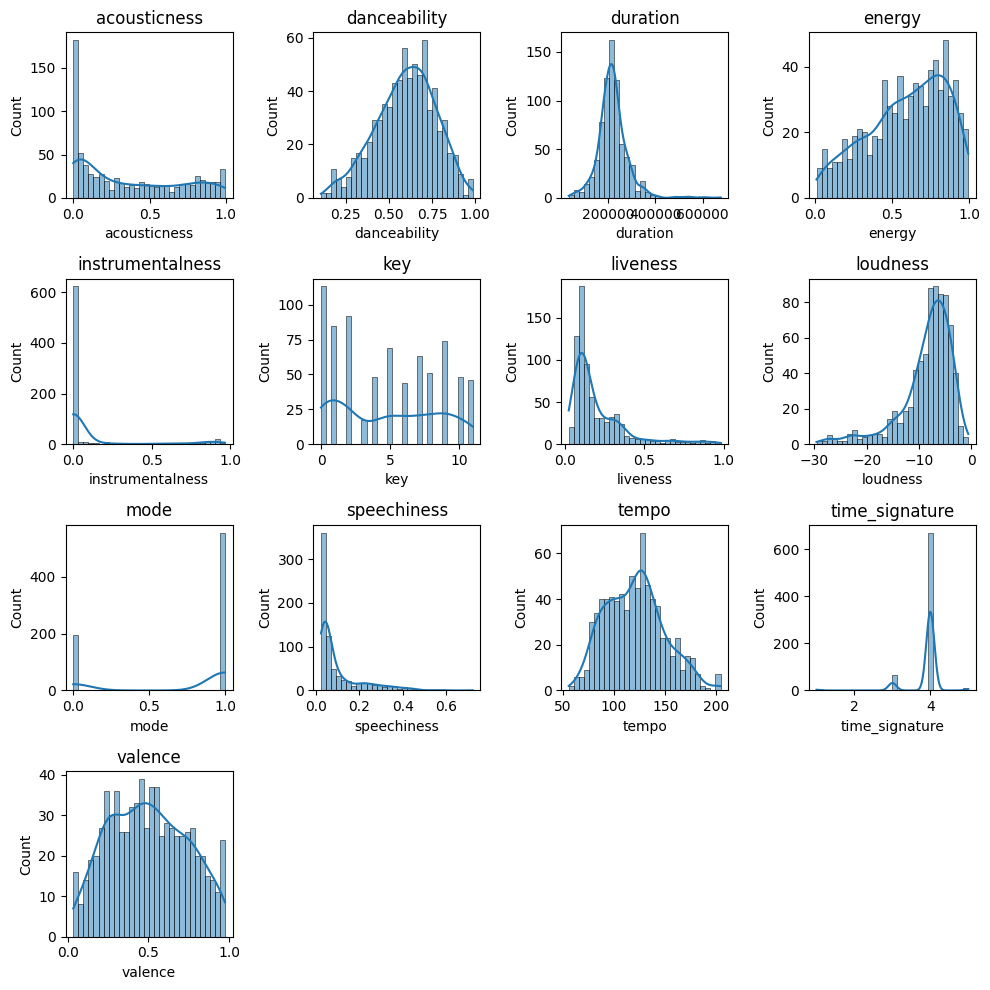

In [12]:
n_cols = 4
n_rows = (len(playlist_spotify.columns) // n_cols + 1)

plt.figure(figsize=(10, 2.5 * n_rows))
for i, column in enumerate(playlist_spotify.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(playlist_spotify[column], kde=True, bins=30)
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

### BoxPlot para cada variable

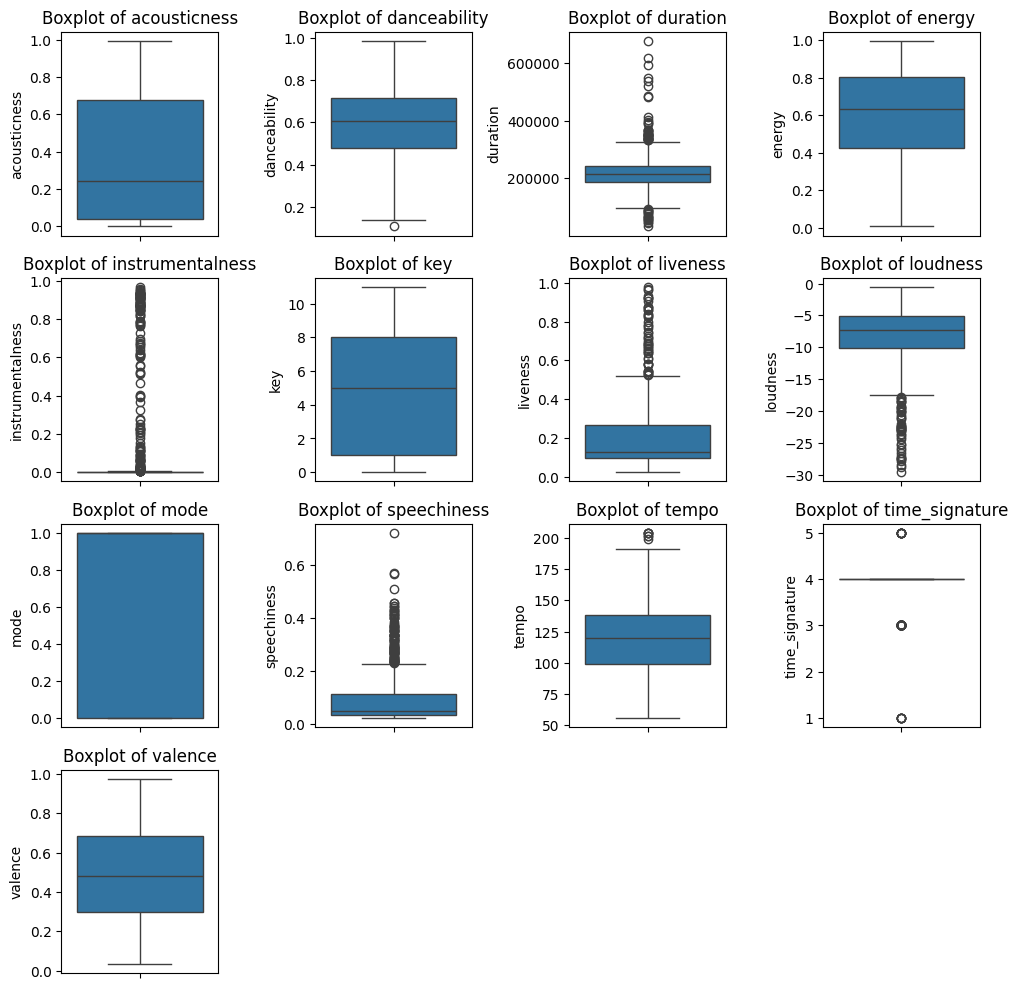

In [13]:
n_cols = 4
n_rows = (len(playlist_spotify.columns) // n_cols + 1)

plt.figure(figsize=(10, 2.5 * n_rows))
for i, column in enumerate(playlist_spotify.columns,1):
    plt.subplot(n_rows, n_cols,i)
    sns.boxplot(y=playlist_spotify[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

## Analisis de correlación

### Matriz de correlación

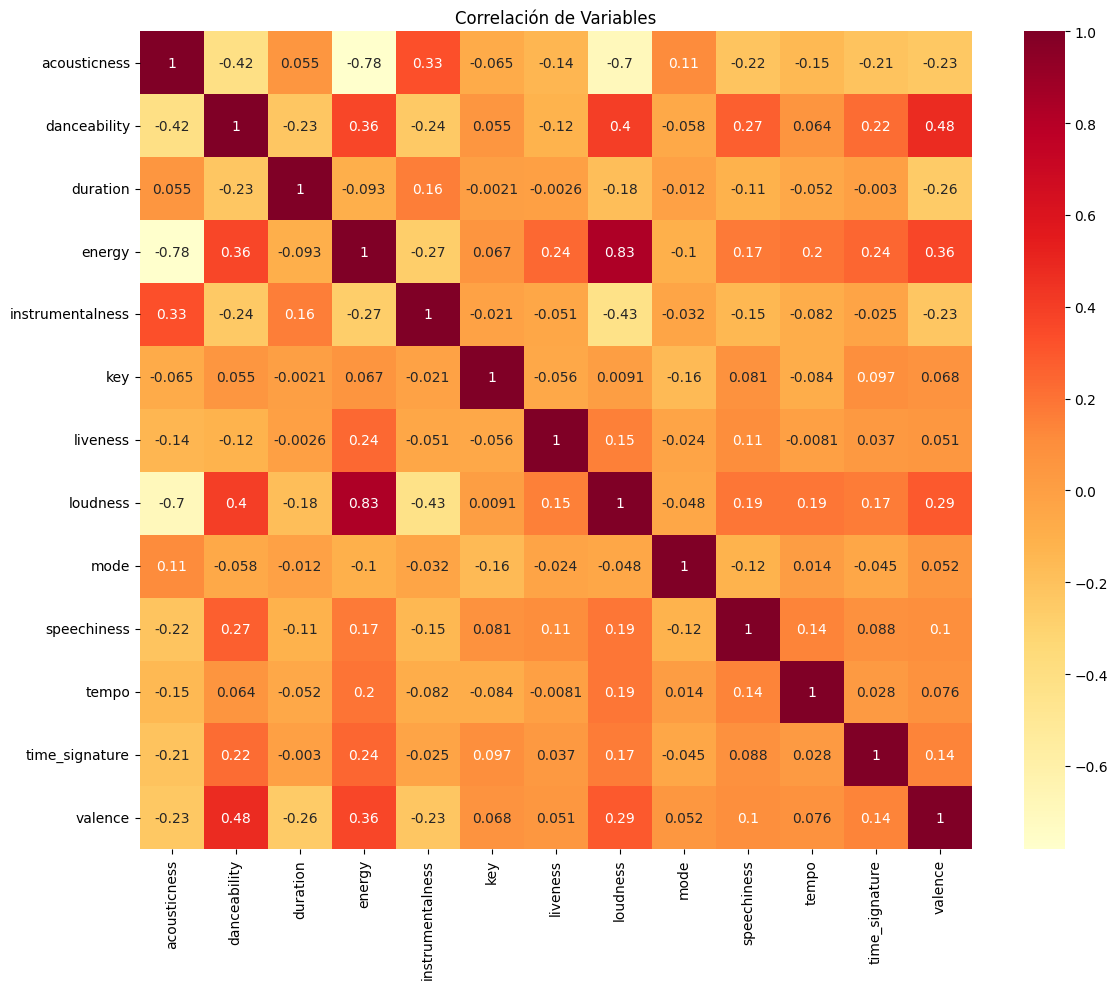

In [14]:
correlation_matrix = playlist_spotify.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlación de Variables')
plt.tight_layout()
plt.show()

### Variables altamente correlacionadas

In [15]:
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i],
                                  correlation_matrix.columns[j],
                                  correlation_matrix.iloc[i, j]))

print("Pares de variables altamente correlacionadas:")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")

Pares de variables altamente correlacionadas:
acousticness - energy: -0.782
energy - loudness: 0.830


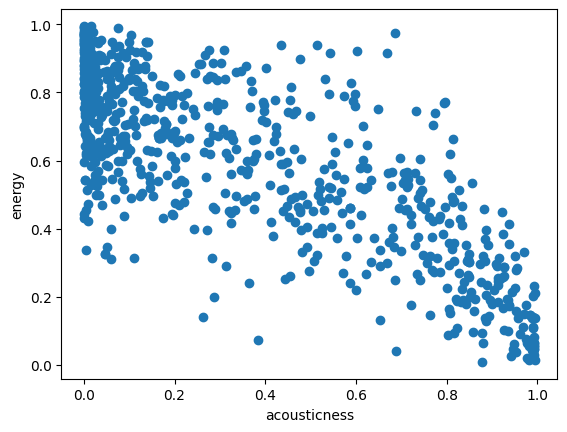

In [16]:
plt.scatter(playlist_spotify['acousticness'], playlist_spotify['energy'])
plt.xlabel('acousticness')
plt.ylabel('energy')
plt.show()

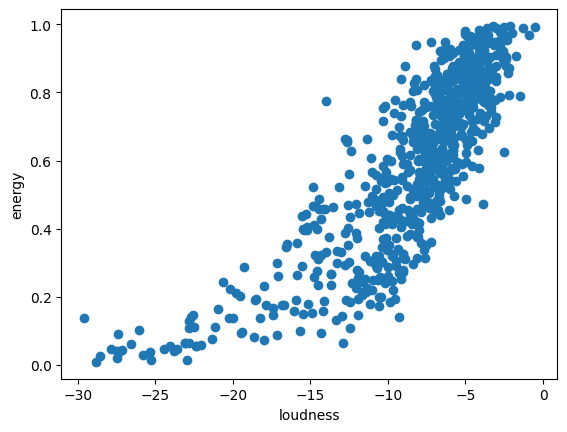

In [17]:
plt.scatter(playlist_spotify['loudness'], playlist_spotify['energy'])
plt.xlabel('loudness')
plt.ylabel('energy')
plt.show()

## Analisis de outliers

In [18]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

In [19]:
def detect_outliers_row(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_df = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers_df

In [20]:
for feature in playlist_spotify.columns:
    outliers = detect_outliers(playlist_spotify, feature)
    print(f"Posibles outliers en {feature}: {len(outliers)} ({len(outliers)/len(playlist_spotify)*100:.2f}%)")

Posibles outliers en acousticness: 0 (0.00%)
Posibles outliers en danceability: 1 (0.13%)
Posibles outliers en duration: 53 (7.07%)
Posibles outliers en energy: 0 (0.00%)
Posibles outliers en instrumentalness: 162 (21.60%)
Posibles outliers en key: 0 (0.00%)
Posibles outliers en liveness: 51 (6.80%)
Posibles outliers en loudness: 49 (6.53%)
Posibles outliers en mode: 0 (0.00%)
Posibles outliers en speechiness: 96 (12.80%)
Posibles outliers en tempo: 7 (0.93%)
Posibles outliers en time_signature: 79 (10.53%)
Posibles outliers en valence: 0 (0.00%)


#### Danceability

In [21]:
outlier_rows = detect_outliers_row(playlist_spotify, 'danceability')
outlier_rows

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
604,0.000003,0.107,277012,0.979,0.93,1,0.475,-5.031,1,0.124,91.066,4,0.0571


In [22]:
Q1 = playlist_spotify['danceability'].quantile(0.25)
Q3 = playlist_spotify['danceability'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
print(f"Limite inferior (moderado): {lower_bound}")

Limite inferior (moderado): 0.12637499999999996


In [23]:
low_values = playlist_spotify[playlist_spotify['danceability'] < lower_bound]
print(f"Cantidad de danceability tracks bajos: {len(low_values)}")

Cantidad de danceability tracks bajos: 1


Sumado a la observación del boxplot, de decide elminarlo.

<Axes: ylabel='danceability'>

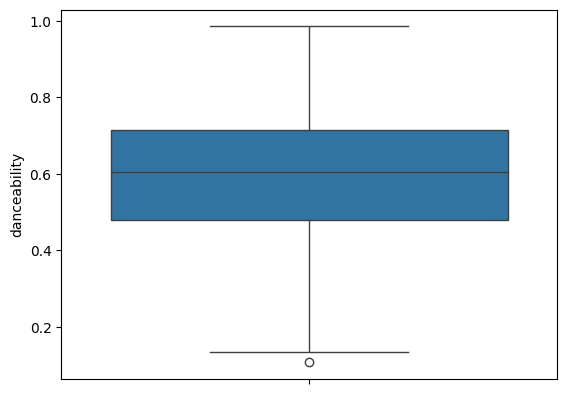

In [24]:
sns.boxplot(y=playlist_spotify['danceability'])

In [25]:
spo = spo[spo['danceability'] > lower_bound]
spo.reset_index(drop=True,inplace=True)

#### Duration

In [26]:
outlier_rows_duration = detect_outliers_row(playlist_spotify, 'duration')
outlier_rows_duration.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
8,0.748,0.420,366179,0.3240,0.839,9,0.0723,-14.700,0,0.0556,183.020,3,0.330
22,0.615,0.499,361613,0.6030,0.000,7,0.2080,-10.022,1,0.3350,128.317,4,0.417
45,0.263,0.579,86813,0.1410,0.000,0,0.2960,-9.288,1,0.1050,128.824,4,0.737
47,0.988,0.318,403280,0.0451,0.888,10,0.0769,-27.127,1,0.0483,79.544,4,0.142
68,0.379,0.719,520661,0.6640,0.000,4,0.9790,-11.361,0,0.2910,109.544,4,0.672


In [27]:
filter_short = 60000 # Filter: 1 min
short_tracks = playlist_spotify[playlist_spotify['duration'] < filter_short]
print(f"Canciones menores a {filter_short}ms: {short_tracks.shape[0]}")

Canciones menores a 60000ms: 6


In [28]:
filter_long = 600000  # Filter: 10 mins
long_tracks = playlist_spotify[playlist_spotify['duration'] > filter_long ]
print(f"Canciones mayores a {filter_long}ms: {long_tracks.shape[0]}")

Canciones mayores a 600000ms: 2


In [29]:
filter_longer = 900000 # Filter: 15 mins
longer = playlist_spotify[playlist_spotify['duration'] > filter_longer ]
longer_count = longer.shape[0]

filter_shorter = 30000 # Filter: 30 sec
shorter = playlist_spotify[playlist_spotify['duration'] < filter_shorter ]
shorter_count = shorter.shape[0]
print(f"Cantidad de tracks cortos (menos de {filter_shorter}ms): {shorter_count}")
print(f"Cantidad de tracks largos (mas de {filter_longer}ms): {longer_count}")

Cantidad de tracks cortos (menos de 30000ms): 0
Cantidad de tracks largos (mas de 900000ms): 0


No se consideran outliers en 'duration'.

#### Liveness



> Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.





<Axes: ylabel='liveness'>

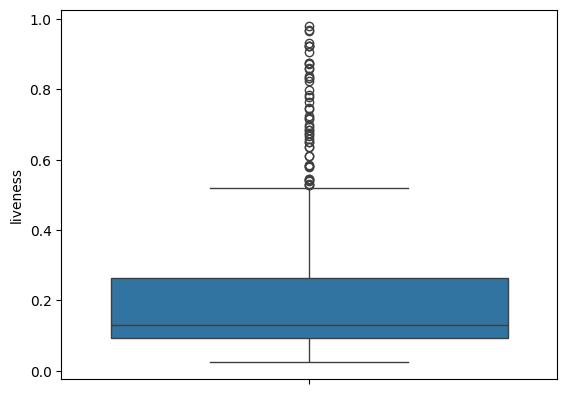

In [30]:
sns.boxplot(y=playlist_spotify['liveness'])

In [31]:
Q1 = playlist_spotify['liveness'].quantile(0.25)
Q3 = playlist_spotify['liveness'].quantile(0.75)
IQR = Q3 - Q1
higher_bound_liv = Q3 + 1.5 * IQR
print({higher_bound_liv})

{np.float64(0.5200500000000001)}


In [32]:
playlist_spotify['liveness'].quantile(0.75)

np.float64(0.26475000000000004)

In [33]:
outliers_liveness = detect_outliers_row(playlist_spotify, 'liveness')
outliers_liveness.shape[0]

51

In [34]:
outliers_liveness[outliers_liveness['liveness'] > 0.8].shape[0]

17

In [35]:
mask = (outliers_liveness['liveness'] < 0.8 ) & (outliers_liveness['liveness'] > higher_bound_liv)

In [36]:
print(f"Outliers entre el limite de los bigotes y el máximo (live track): {outliers_liveness[mask].shape[0]}")

Outliers entre el limite de los bigotes y el máximo (live track): 34


#### Loudness

Loudness:

> (...) Values typically range between -60 and 0 db



In [37]:
outlier_rows_loudness = detect_outliers_row(playlist_spotify, 'loudness')
outlier_rows_loudness.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
18,0.992,0.525,226293,0.0633,0.905,9,0.1050,-23.072,1,0.0497,71.855,4,0.2970
25,0.994,0.450,199493,0.0153,0.919,2,0.0630,-25.257,1,0.0552,81.327,4,0.2260
32,0.983,0.311,124067,0.1470,0.000,10,0.1070,-22.533,1,0.0567,77.834,4,0.3870
35,0.962,0.211,103867,0.0904,0.881,8,0.1830,-27.385,1,0.0385,82.279,3,0.0652
47,0.988,0.318,403280,0.0451,0.888,10,0.0769,-27.127,1,0.0483,79.544,4,0.1420


In [38]:
filter_max = 0
max_loudness = playlist_spotify[playlist_spotify['loudness'] > filter_max]
print(f"Tracks con loudness superior a {filter_max} db: {max_loudness.shape[0]}")

Tracks con loudness superior a 0 db: 0


In [39]:
filter_min = -60
min_loudness = playlist_spotify[playlist_spotify['loudness'] < filter_min]
print(f"Tracks con loudness inferior a {filter_min} db: {min_loudness.shape[0]}")

Tracks con loudness inferior a -60 db: 0


#### Tempo

In [40]:
outlier_rows_tempo = detect_outliers_row(playlist_spotify, 'tempo')
outlier_rows_tempo.shape[0]

7

In [41]:
outlier_rows_tempo

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
10,0.530000,0.525,206249,0.574,0.000007,1,0.3140,-6.448,0,0.2960,199.512,4,0.420
195,0.000146,0.774,181400,0.431,0.000020,1,0.1120,-8.407,1,0.3460,201.843,4,0.353
350,0.005820,0.743,238373,0.339,0.000000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118
377,0.028300,0.522,191093,0.526,0.000376,0,0.1310,-8.790,1,0.0354,203.669,4,0.530
649,0.000107,0.766,181573,0.442,0.000061,1,0.1110,-8.558,1,0.3560,201.800,4,0.390
654,0.018500,0.703,207408,0.851,0.000244,7,0.1020,-6.813,1,0.3530,203.988,4,0.879
743,0.125000,0.480,110075,0.560,0.000000,1,0.1360,-7.868,1,0.3510,204.162,4,0.571


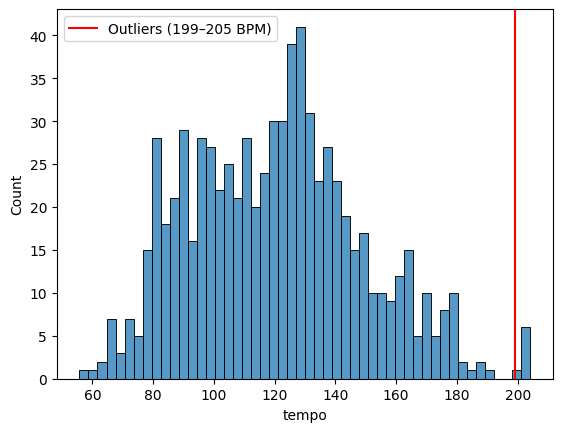

In [42]:
sns.histplot(playlist_spotify['tempo'], bins=50)
plt.axvline(x=199, color='red', label='Outliers (199–205 BPM)')
plt.legend()

In [43]:
mask_tempo2 = (playlist_spotify['tempo'] > 180)
filtered_tempo = playlist_spotify[mask_tempo2]['tempo']
counts_tempo = filtered_tempo.value_counts().sort_index()

¿Como interpretarlo?

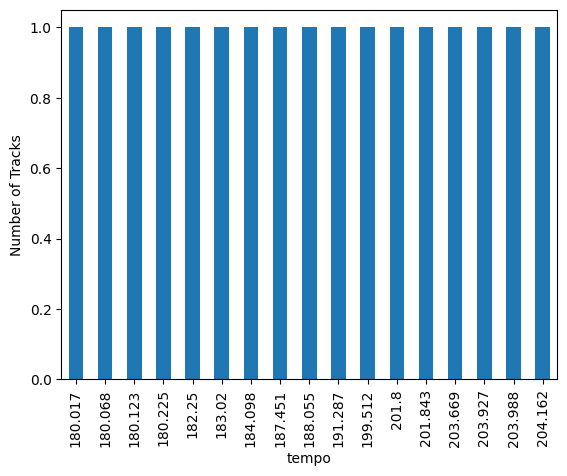

In [44]:
counts_tempo.plot(kind='bar')
plt.xlabel('tempo')
plt.ylabel('Number of Tracks')
plt.show()

#### Time signature

In [45]:
outlier_rows_time_signature = detect_outliers_row(playlist_spotify, 'time_signature')
outlier_rows_time_signature.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
8,0.7480,0.420,366179,0.3240,0.839000,9,0.0723,-14.700,0,0.0556,183.020,3,0.3300
34,0.9510,0.662,206467,0.2270,0.000000,2,0.0613,-12.030,1,0.1080,116.003,5,0.6290
35,0.9620,0.211,103867,0.0904,0.881000,8,0.1830,-27.385,1,0.0385,82.279,3,0.0652
53,0.9340,0.580,187427,0.1010,0.000302,10,0.0768,-15.661,1,0.0289,91.003,3,0.3020
54,0.0469,0.311,208467,0.3250,0.000000,2,0.1390,-9.042,1,0.0283,65.090,1,0.6680


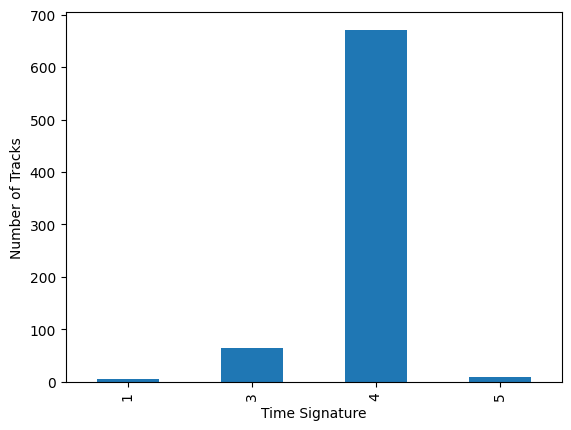

In [46]:
playlist_spotify['time_signature'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Time Signature')
plt.ylabel('Number of Tracks')
plt.show()

time_signature:
> An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4"

In [47]:
odd_tracks = playlist_spotify[playlist_spotify['time_signature'] == 1]
print(f"Cantidad de tracks con tempo fuera de rango: {odd_tracks.shape[0]}")

Cantidad de tracks con tempo fuera de rango: 6


In [48]:
odd_tracks

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
54,0.04690,0.311,208467,0.3250,0.00000,2,0.1390,-9.042,1,0.0283,65.090,1,0.6680
83,0.04690,0.311,208467,0.3250,0.00000,2,0.1390,-9.042,1,0.0283,65.090,1,0.6680
316,0.92300,0.173,312400,0.1670,0.01240,2,0.1100,-17.398,1,0.0409,71.746,1,0.0332
433,0.14400,0.904,111304,0.5550,0.00864,5,0.1150,-5.157,1,0.0820,138.084,1,0.5020
502,0.00216,0.442,215110,0.7390,0.00169,1,0.0854,-4.084,1,0.0598,108.288,1,0.2290
593,0.97700,0.350,261107,0.0652,0.25200,3,0.2190,-22.807,1,0.0431,144.171,1,0.1440


Se decide elminarlos, son outliers basandose la documentación del dataset.

In [49]:
spo = spo[spo['time_signature'] != 1]
spo.reset_index(drop=True,inplace=True)

#### Speechiness


> Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.



In [50]:
outlier_rows_speechiness = detect_outliers_row(playlist_spotify, 'speechiness')
outlier_rows_speechiness.shape[0]

96

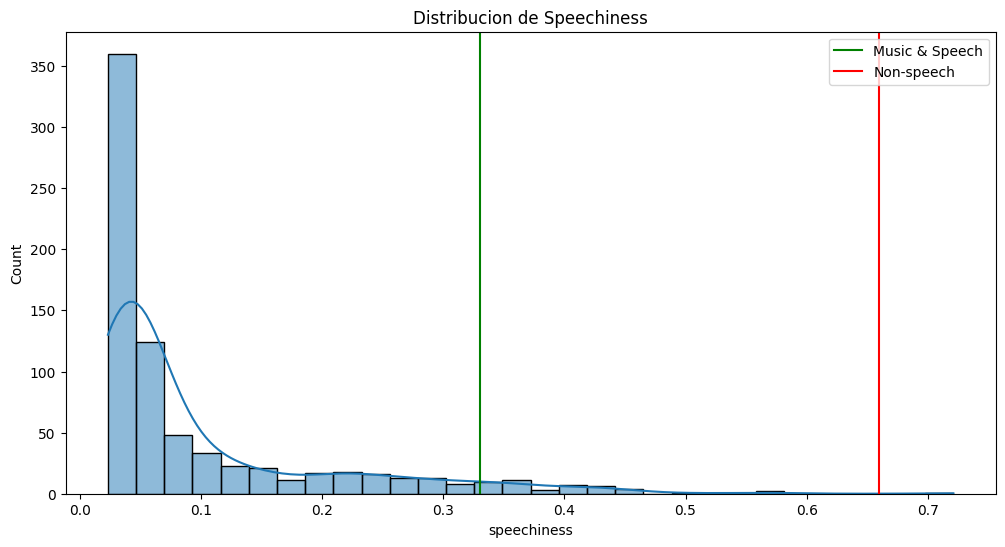

In [51]:
plt.figure(figsize=(12, 6))
sns.histplot(playlist_spotify['speechiness'], bins=30, kde=True)
plt.axvline(x=0.33, color='green', label='Music & Speech')
plt.axvline(x=0.66, color='red', label='Non-speech')
plt.legend()
plt.title('Distribucion de Speechiness')
plt.show()

<Axes: ylabel='speechiness'>

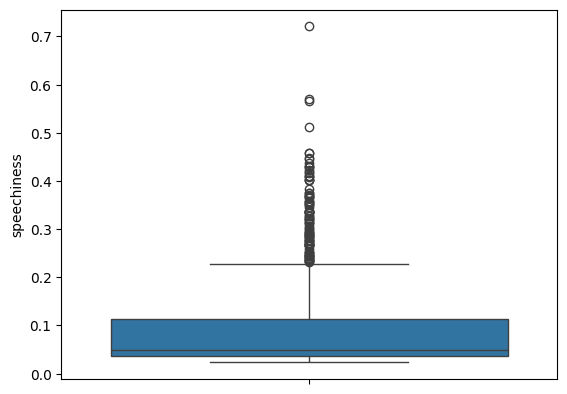

In [52]:
sns.boxplot(y=playlist_spotify['speechiness'])

In [53]:
playlist_spotify[playlist_spotify['speechiness'] > 0.66]

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
235,0.652,0.627,219040,0.132,0.0,0,0.43,-13.357,1,0.721,167.127,4,0.256


In [54]:
playlist_spotify[playlist_spotify['speechiness'] > 0.5]

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
121,0.24100,0.441,226829,0.752,0.000000,11,0.408,-6.976,0,0.570,163.987,4,0.409
235,0.65200,0.627,219040,0.132,0.000000,0,0.430,-13.357,1,0.721,167.127,4,0.256
532,0.00898,0.635,170638,0.472,0.000000,8,0.117,-3.869,0,0.511,174.008,4,0.373
677,0.27600,0.568,210053,0.654,0.000008,8,0.321,-7.603,1,0.567,76.987,4,0.322


Se decide eliminar valor con speechiness > 0.66. Según la documentación se trata de tracks puramente vocales y aquí se están analizando solo canciones. Valores entre 0.33 y 0.66 pueden tratarse de canciones.

In [55]:
spo = spo[spo['speechiness'] < 0.66]
spo.reset_index(drop=True,inplace=True)

## Analisis del data set filtrado

In [56]:
scaler = StandardScaler()

X_scaled_spo = scaler.fit_transform(spo)
X_scaled_spo_df = pd.DataFrame(X_scaled_spo, columns=spo.columns)

X_scaled_spo_df.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1.053548,-0.497671,-1.827058,-0.298452,2.763964,0.863111,-0.513211,-1.265817,-1.680697,-0.527560,-0.024049,0.243208,-1.492381
1,-0.490404,0.679929,-0.198427,0.070821,-0.384718,-0.236337,0.335945,0.309051,0.594991,-0.649424,0.120920,0.243208,0.346719
2,-0.072559,0.185337,-0.058546,-0.560516,-0.384704,0.038525,-0.428858,-0.160419,0.594991,-0.675746,0.686688,0.243208,-1.257780
3,0.721643,1.245178,-1.274176,-1.489653,0.425605,0.038525,-0.108316,-0.502305,0.594991,-0.542184,-0.375625,0.243208,1.251606
4,1.557333,-0.786183,-0.588148,-0.544633,-0.384050,0.313387,-0.753899,0.069432,-1.680697,-0.618227,-1.054497,0.243208,-0.884933


In [57]:
H_spo = hopkins_st(X_scaled_spo_df.values, sample_size=0.05, random_state=42)
print(f"Hopkins Statistic: {H_spo}")

Hopkins Statistic: 0.7326240066934986


Dismiuye la tendencia al cluster. Se decide tratar el data set original.

## Normalización de los datos

In [58]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(playlist_spotify)

In [59]:
X_scaled_df = pd.DataFrame(X_scaled, columns=playlist_spotify.columns)
X_scaled_df.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1.051530,-0.479513,-1.830645,-0.289129,2.755574,0.872602,-0.514824,-1.256057,-1.692920,-0.521443,-0.018575,0.24344,-1.479699
1,-0.489072,0.683807,-0.199770,0.078268,-0.385931,-0.228242,0.335928,0.312609,0.590695,-0.640895,0.125647,0.24344,0.353630
2,-0.072134,0.195213,-0.059696,-0.549862,-0.385917,0.046969,-0.430312,-0.155012,0.590695,-0.666697,0.688498,0.24344,-1.245835
3,0.720345,1.242201,-1.277002,-1.474280,0.422545,0.046969,-0.109167,-0.495552,0.590695,-0.535778,-0.368338,0.24344,1.255678
4,1.554221,-0.764526,-0.590027,-0.534060,-0.385265,0.322180,-0.755964,0.073934,-1.692920,-0.610315,-1.043710,0.24344,-0.874157


## Reucción de la dimensionalidad

### PCA

In [60]:
target_columns = ['acousticness','danceability','energy','instrumentalness',
            'liveness','loudness','speechiness','tempo','valence']

In [61]:
x = playlist_spotify.loc[:, target_columns].values
X_scaled_target = StandardScaler().fit_transform(x)

In [62]:
H = hopkins_st(X_scaled_target, sample_size=0.05, random_state=42)
print(f"Hopkins Statistic: {H}")

Hopkins Statistic: 0.7865562436066339


In [63]:
pca = PCA(n_components=0.95)
X_pca = pca.fit(X_scaled)

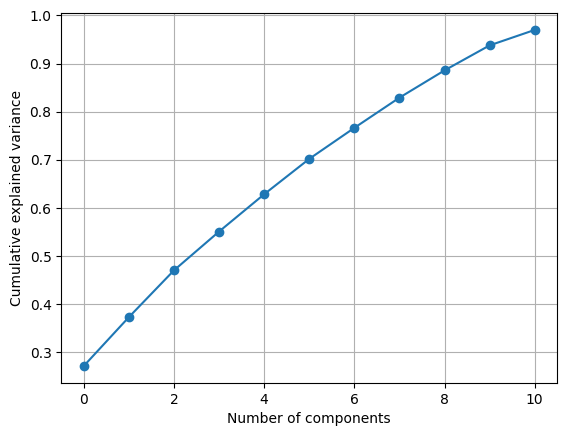

In [64]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()

In [65]:
pca.explained_variance_ratio_

array([0.27192027, 0.10137918, 0.09718107, 0.08058426, 0.07743641,
       0.07346572, 0.06440751, 0.06272123, 0.0566788 , 0.05192418,
       0.03208224])

In [66]:
pca.get_covariance()

array([[ 0.96142409, -0.42798359,  0.04725694, -0.77034306,  0.32489117,
        -0.06886159, -0.14351413, -0.74804621,  0.113979  , -0.21588112,
        -0.14917597, -0.20685697, -0.22902921],
       [-0.42798359,  0.99919419, -0.23352437,  0.36663635, -0.2414202 ,
         0.0543872 , -0.1167879 ,  0.38181935, -0.05799643,  0.27268251,
         0.06416026,  0.22249901,  0.48482321],
       [ 0.04725694, -0.23352437,  1.00043837, -0.09685057,  0.16195265,
        -0.00244105, -0.00268806, -0.18418753, -0.01190818, -0.11086886,
        -0.05218124, -0.00289178, -0.25560254],
       [-0.77034306,  0.36663635, -0.09685057,  1.0493667 , -0.27816654,
         0.0649741 ,  0.2327901 ,  0.79135316, -0.10087097,  0.17432405,
         0.19682705,  0.23963543,  0.35630663],
       [ 0.32489117, -0.2414202 ,  0.16195265, -0.27816654,  1.00290199,
        -0.02065008, -0.05030884, -0.42632639, -0.03245542, -0.14546519,
        -0.08130903, -0.02415458, -0.22652541],
       [-0.06886159,  0.054387

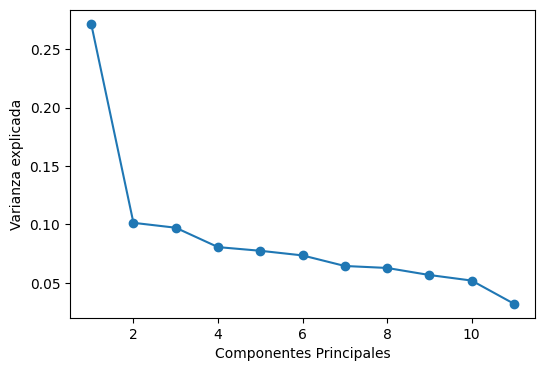

In [67]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada, '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Varianza explicada')
plt.show()

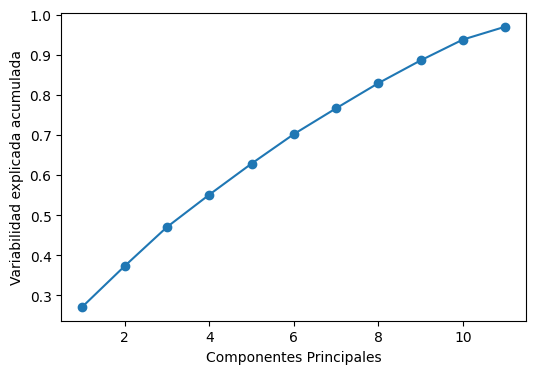

In [68]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada acumulada')
plt.show()

10 componetes parecería lo adecuado según PCA

----------------------------

In [69]:
pca = PCA(n_components=0.95)
X_pca_v2 = pca.fit(X_scaled_target)

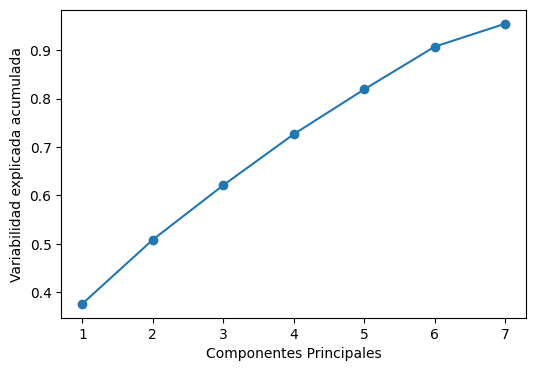

In [70]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada acumulada')
plt.show()

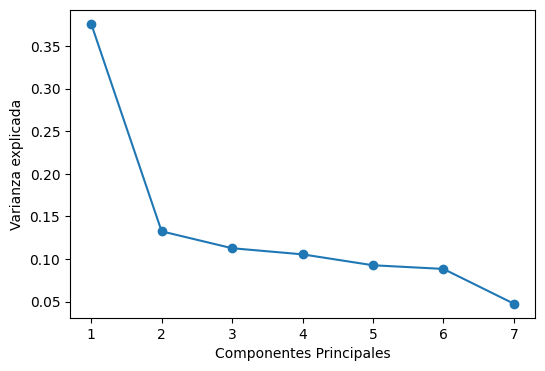

In [71]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada, '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Varianza explicada')
plt.show()

6 para ser un buen numero

### t-SNE

In [72]:
from sklearn.manifold import TSNE

In [73]:
from sklearn.pipeline import make_pipeline

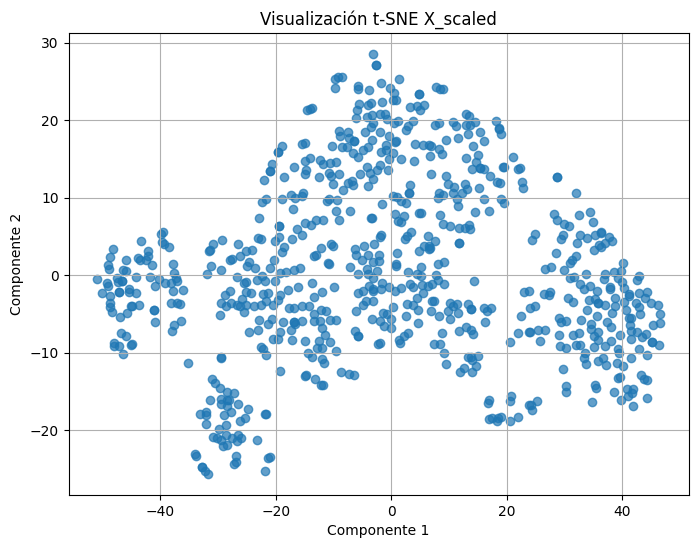

In [74]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.title('Visualización t-SNE X_scaled')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

------------------------

In [75]:
pcaT_v1 = PCA(n_components=10)
X_pca_v1 = pca.fit_transform(X_scaled)
print("PCA output shape:", X_pca_v1.shape)

PCA output shape: (750, 11)


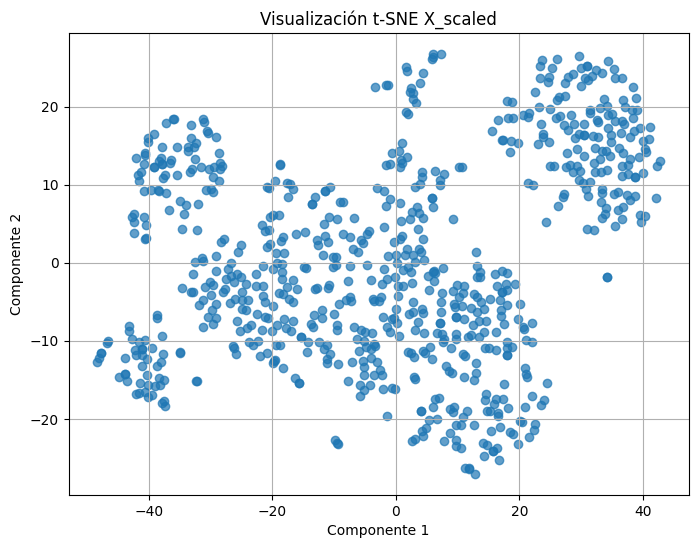

In [76]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca_v1)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.title('Visualización t-SNE X_scaled')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

-----------------------

In [77]:
pcaT_v2 = PCA(n_components=6)
X_pca_v2 = pca.fit_transform(X_scaled_target)
print("PCA output shape:", X_pca_v2.shape)

PCA output shape: (750, 7)


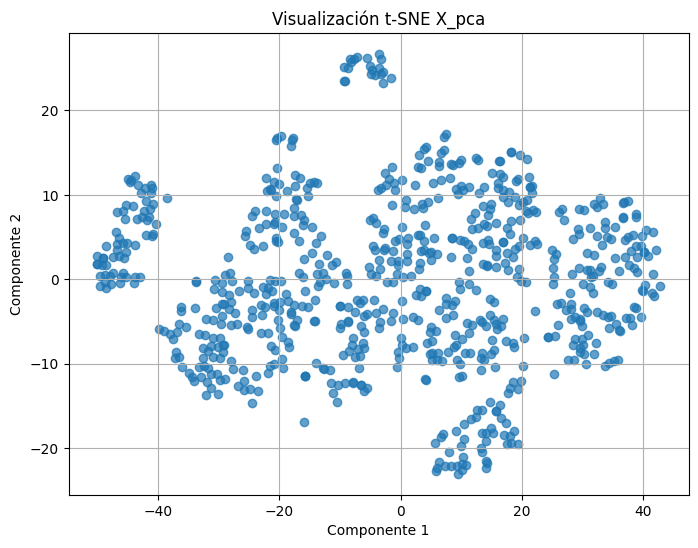

In [78]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_pca_v2)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.title('Visualización t-SNE X_pca')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

## Estimar cantidad de conjuntos

### Elbow Method y Silhouette

In [79]:
Total_variation = []
Silhouette = []

In [80]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    Silhouette.append(silhouette_score(X_scaled, kmeans.labels_))
    Total_variation.append(kmeans.inertia_)

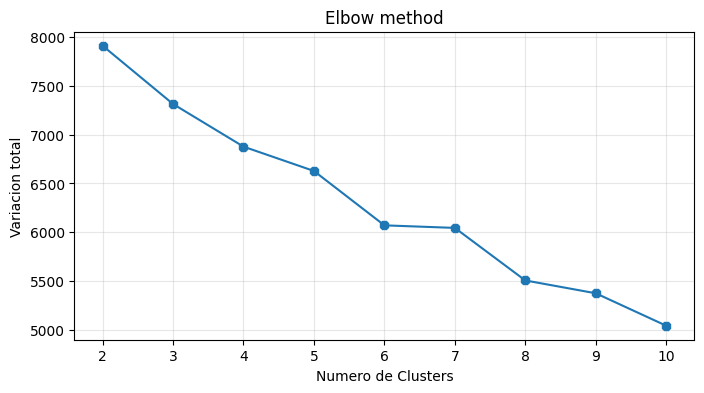

In [81]:
plt.figure(figsize=(8,4))

plt.plot(range(2, 11), Total_variation, marker='8')
plt.xlabel('Numero de Clusters')
plt.ylabel('Variacion total')
plt.title("Elbow method")
plt.grid(True, alpha=0.3)
plt.show()

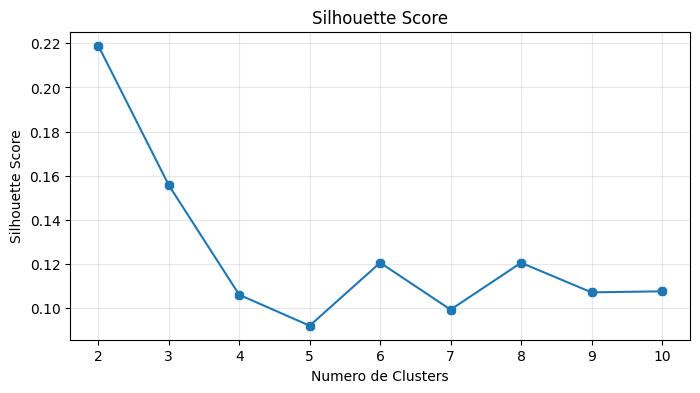

In [82]:
plt.figure(figsize=(8,4))

plt.plot(range(2, 11), Silhouette, marker='8')
plt.xlabel('Numero de Clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.show()

In [83]:
LoopResults = pd.DataFrame(np.arange(2,11,1),columns = ['K value'])
LoopResults['Variacion total'] = Total_variation
LoopResults['Silhouette Score'] = Silhouette
print(LoopResults)

   K value  Variacion total  Silhouette Score
0        2      7911.477476          0.218915
1        3      7314.015797          0.155748
2        4      6876.979590          0.106102
3        5      6627.275839          0.092096
4        6      6070.002783          0.120641
5        7      6043.754581          0.099384
6        8      5505.103213          0.120604
7        9      5373.552622          0.107212
8       10      5040.964859          0.107671


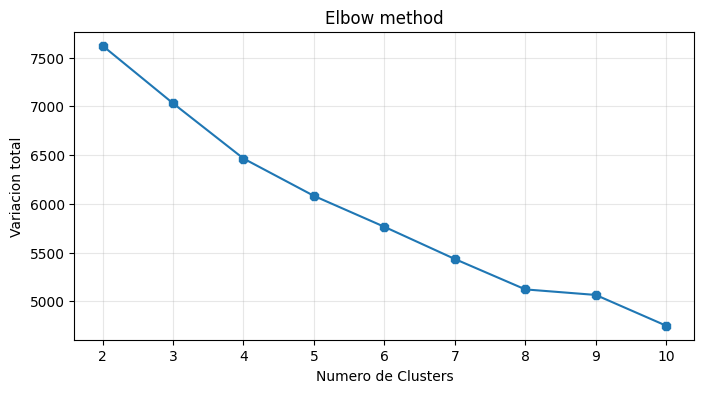

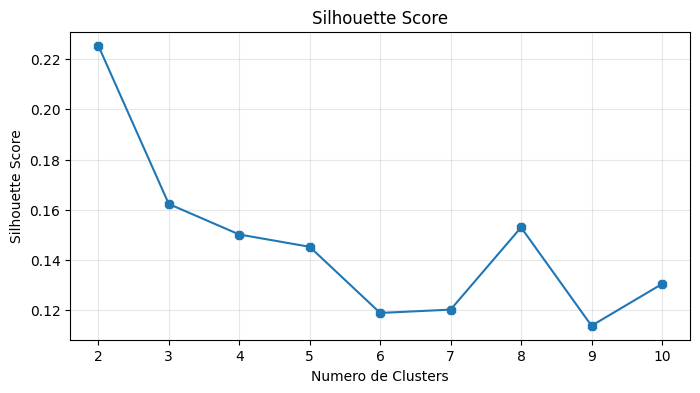

In [84]:
Total_variation_v2 = []
Silhouette_v2 = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_pca_v1)
    Silhouette_v2.append(silhouette_score(X_pca_v1, kmeans.labels_))
    Total_variation_v2.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(2, 11), Total_variation_v2, marker='8')
plt.xlabel('Numero de Clusters')
plt.ylabel('Variacion total')
plt.title("Elbow method")
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(8,4))
plt.plot(range(2, 11), Silhouette_v2, marker='8')
plt.xlabel('Numero de Clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.show()

In [85]:
LoopResults = pd.DataFrame(np.arange(2,11,1),columns = ['K value'])
LoopResults['Variacion total'] = Total_variation_v2
LoopResults['Silhouette Score'] = Silhouette_v2
print(LoopResults)

   K value  Variacion total  Silhouette Score
0        2      7620.948236          0.225293
1        3      7030.319921          0.162300
2        4      6463.835887          0.150154
3        5      6080.753215          0.145257
4        6      5763.504682          0.118933
5        7      5433.251574          0.120252
6        8      5121.692689          0.152988
7        9      5064.771827          0.113845
8       10      4749.122297          0.130441


In [86]:
from yellowbrick.cluster import SilhouetteVisualizer

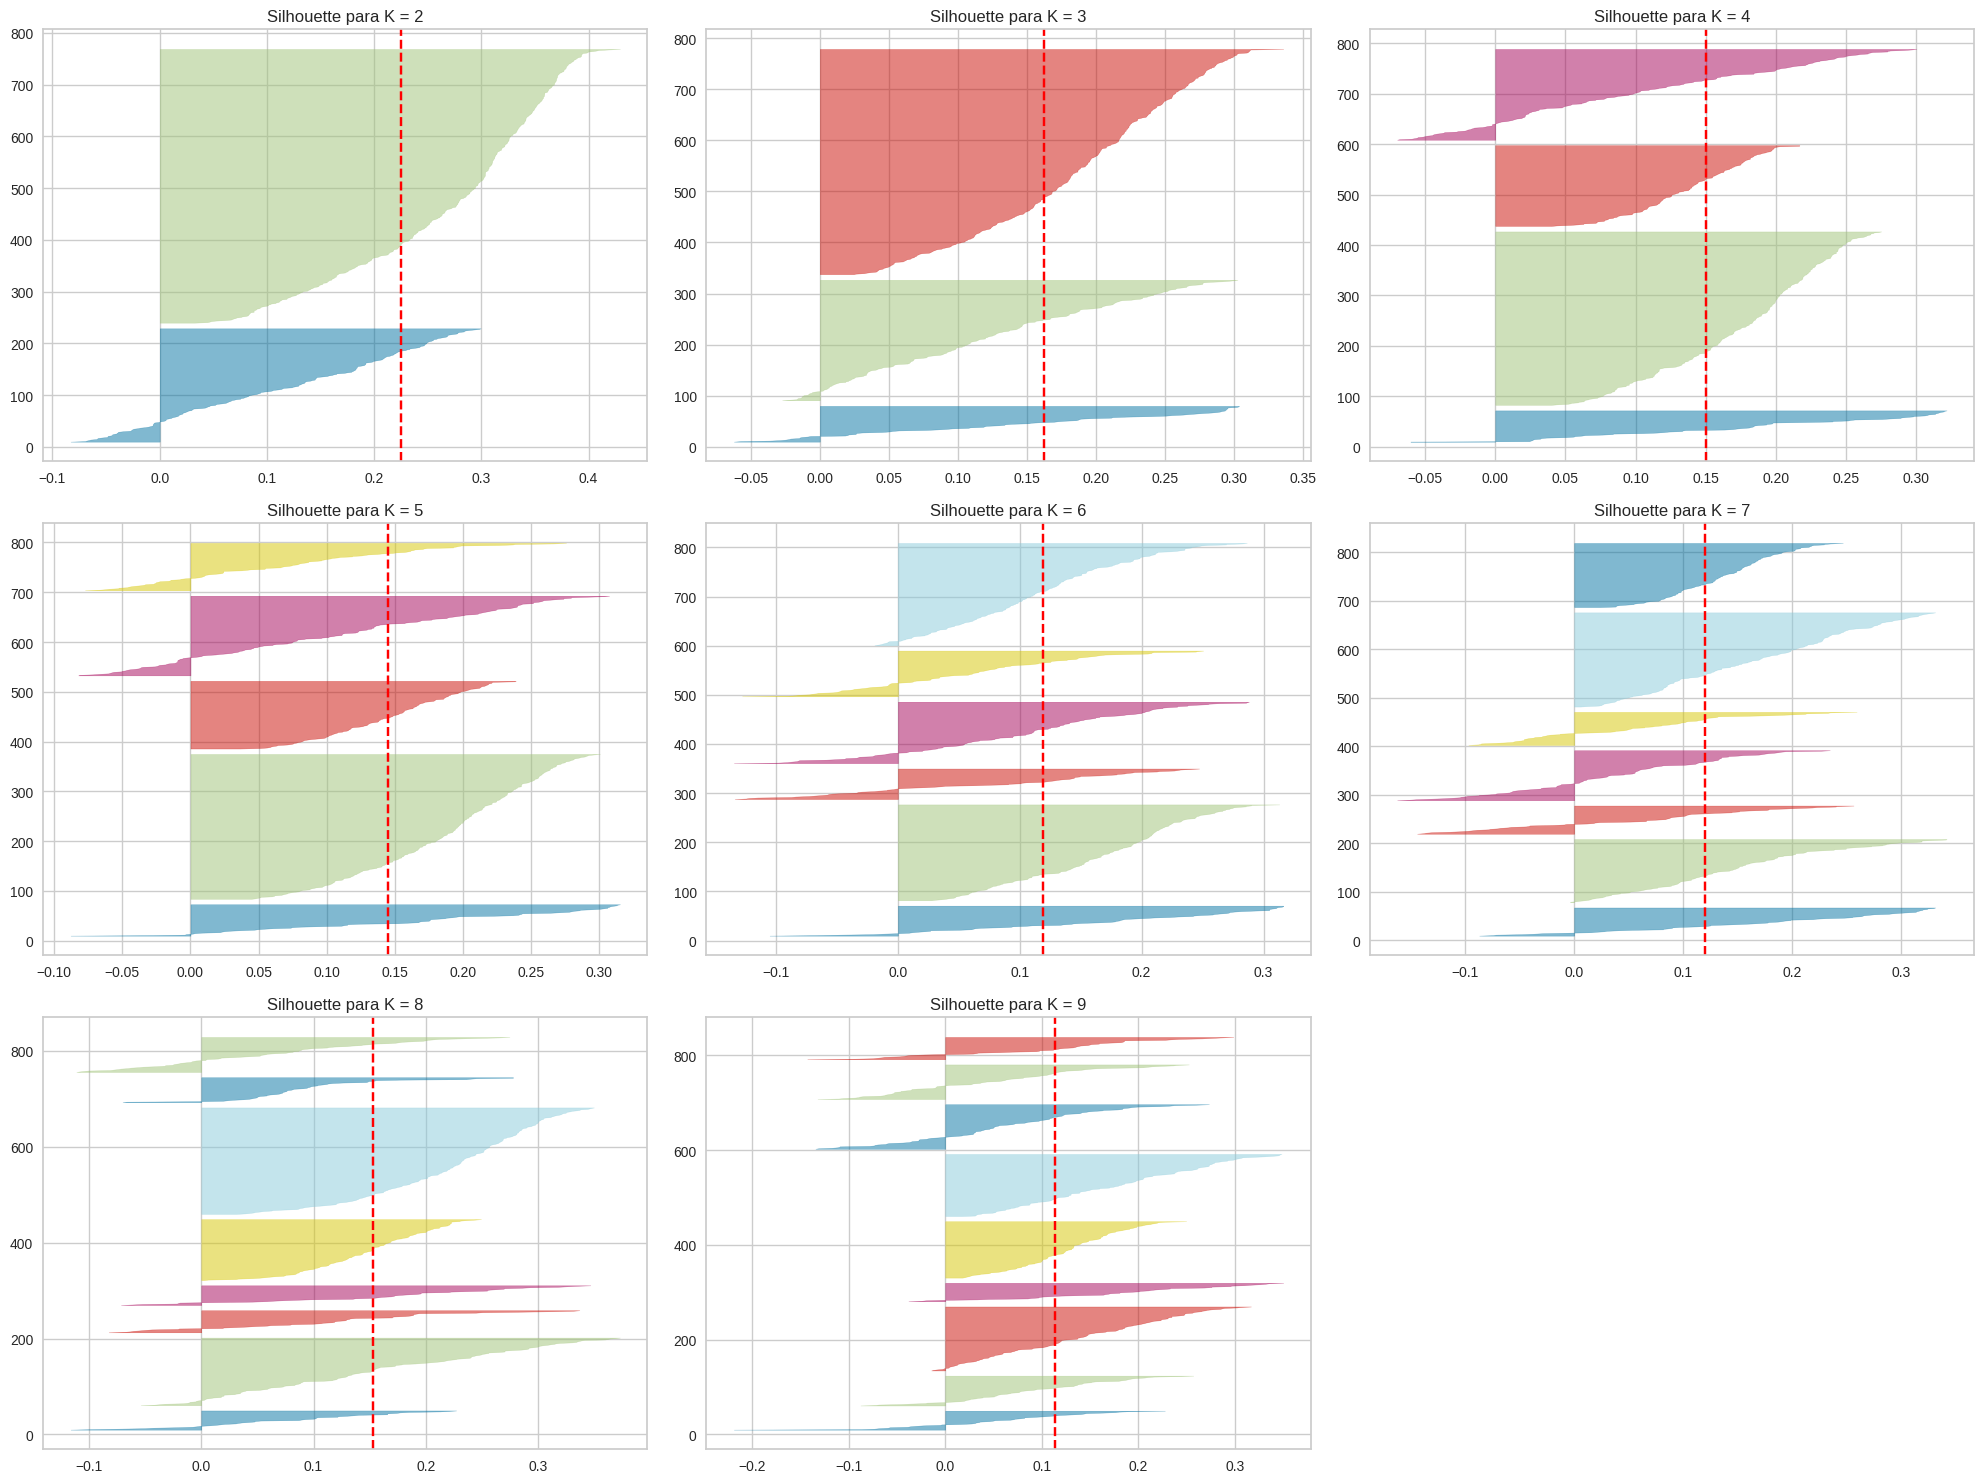

In [87]:
n_cols = 3
k_values = range(2, 10)
n_rows = (len(k_values) // n_cols + 1)

plt.figure(figsize=(20, 5 * n_rows))

for i, k in enumerate(k_values, 1):
    plt.subplot(n_rows, n_cols, i)


    model = KMeans(k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X_pca_v1)
    visualizer.set_title(f"Silhouette para K = {k}")

plt.tight_layout()
plt.show()

## K-Means

In [88]:
kmeans = KMeans(n_clusters=8, random_state=42)
playlist_spotify['cluster'] = kmeans.fit_predict(X_pca_v1)

In [89]:
playlist_spotify.groupby('cluster').mean().round(2)

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
cluster,,,,,,,,,,,,,
0,0.54,0.57,225920.71,0.55,0.79,4.49,0.18,-10.07,0.73,0.06,126.58,3.93,0.47
1,0.61,0.52,219289.12,0.38,0.01,4.29,0.15,-10.78,0.94,0.05,117.98,4.02,0.40
2,0.23,0.54,225033.55,0.73,0.07,4.11,0.74,-7.28,0.79,0.11,115.53,3.96,0.52
3,0.95,0.36,294576.81,0.11,0.70,4.93,0.12,-22.14,0.71,0.05,96.23,3.88,0.22
4,0.16,0.65,214779.51,0.72,0.03,6.09,0.18,-6.10,0.00,0.10,118.90,3.98,0.51
5,0.15,0.68,215528.95,0.77,0.01,4.75,0.17,-5.64,1.00,0.07,122.15,4.01,0.62
6,0.68,0.45,210321.58,0.34,0.03,3.83,0.15,-11.30,0.87,0.06,118.51,2.77,0.37
7,0.25,0.69,203137.39,0.65,0.01,5.22,0.19,-7.14,0.76,0.35,137.16,4.00,0.53


In [90]:
print(playlist_spotify.groupby('cluster').mean().round(2))

         acousticness  danceability   duration  energy  instrumentalness  \
cluster                                                                    
0                0.54          0.57  225920.71    0.55              0.79   
1                0.61          0.52  219289.12    0.38              0.01   
2                0.23          0.54  225033.55    0.73              0.07   
3                0.95          0.36  294576.81    0.11              0.70   
4                0.16          0.65  214779.51    0.72              0.03   
5                0.15          0.68  215528.95    0.77              0.01   
6                0.68          0.45  210321.58    0.34              0.03   
7                0.25          0.69  203137.39    0.65              0.01   

          key  liveness  loudness  mode  speechiness   tempo  time_signature  \
cluster                                                                        
0        4.49      0.18    -10.07  0.73         0.06  126.58            3.93   

In [91]:
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(X_pca_v1)

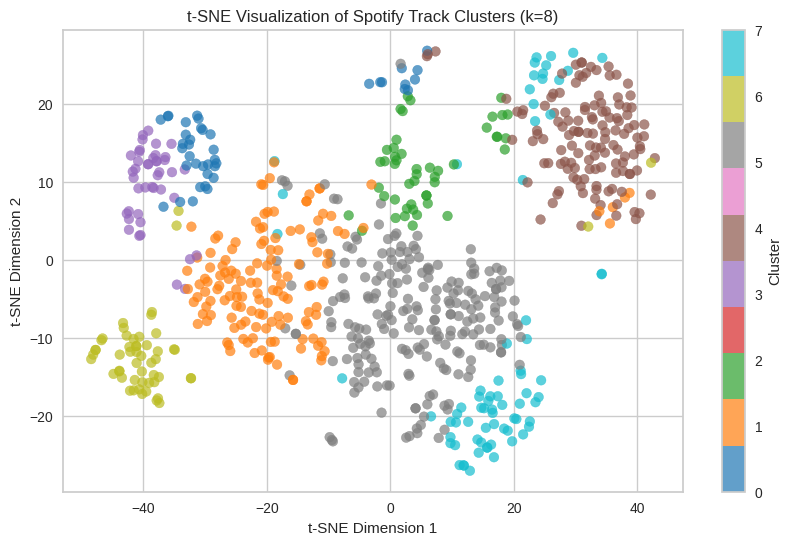

In [92]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca_v1)

# Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title('t-SNE Visualization of Spotify Track Clusters (k=8)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()